# Time Series Data Analysis

In [50]:
# Import required libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit

In [3]:
# Reading data.
filepath = "../../../Data/future_sales/sales_train.csv"
stores_data = pd.read_csv(filepath, 
                          date_format="%d.%m.%Y",
                          parse_dates=["date"])

In [4]:
# Splitting data to avoid data snooping
split = StratifiedShuffleSplit(n_splits=1)
for train_index, test_index in split.split(stores_data, stores_data['shop_id']):
    stores_train_data = stores_data.loc[train_index,:]
    stores_test_data = stores_data.loc[test_index,:]

stores_train_data = stores_train_data.sort_values(by="date").reset_index()
stores_test_data = stores_test_data.sort_values(by="date").reset_index()
stores_train_data = stores_train_data.drop(["index", "date_block_num"], axis=1)
stores_test_data = stores_test_data.drop(["index", "date_block_num"], axis=1)

## Quick data exploration
- Want to know the columns and data types
- Basic statistics of the data

In [6]:
stores_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2642264 entries, 0 to 2642263
Data columns (total 5 columns):
 #   Column        Dtype         
---  ------        -----         
 0   date          datetime64[ns]
 1   shop_id       int64         
 2   item_id       int64         
 3   item_price    float64       
 4   item_cnt_day  float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 100.8 MB


In [7]:
stores_train_data.head()

,date,shop_id,item_id,item_price,item_cnt_day
0,2013-01-01,54,8022,20.0,1.0
1,2013-01-01,28,19637,399.0,1.0
2,2013-01-01,27,7820,2290.0,1.0
3,2013-01-01,54,15779,199.0,1.0
4,2013-01-01,14,2321,999.0,1.0


In [8]:
stores_train_data.describe()

,date,shop_id,item_id,item_price,item_cnt_day
count,2642264,2.642264e+06,2.642264e+06,2.642264e+06,2.642264e+06
mean,2014-04-03 03:44:32.998609152,3.300172e+01,1.019607e+04,8.912443e+02,1.243171e+00
min,2013-01-01 00:00:00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,2013-08-01 00:00:00,2.200000e+01,4.475000e+03,2.490000e+02,1.000000e+00
50%,2014-03-04 00:00:00,3.100000e+01,9.336000e+03,3.990000e+02,1.000000e+00
75%,2014-12-05 00:00:00,4.700000e+01,1.568300e+04,9.990000e+02,1.000000e+00
max,2015-10-31 00:00:00,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03
std,NaN,1.622698e+01,6.324217e+03,1.732612e+03,2.668694e+00


# Exploratory Data Analysis

In [10]:
# Number of objects in the dataframe.
num_objects = stores_train_data.nunique()
display(num_objects)

date             1034
shop_id            60
item_id         21543
item_price      18844
item_cnt_day      193
dtype: int64

In [11]:
# Checking if there are any nulls.
for col in stores_train_data.columns:
    check_null = stores_train_data[col].isnull().value_counts()
    print(check_null)
    print(f"{'-'*30}")

date
False    2642264
Name: count, dtype: int64
------------------------------
shop_id
False    2642264
Name: count, dtype: int64
------------------------------
item_id
False    2642264
Name: count, dtype: int64
------------------------------
item_price
False    2642264
Name: count, dtype: int64
------------------------------
item_cnt_day
False    2642264
Name: count, dtype: int64
------------------------------


In [90]:
items_not_returned = stores_train_data.loc[(stores_train_data['item_cnt_day'] > 0),['item_cnt_day']]
items_returned = stores_train_data.loc[(stores_train_data['item_cnt_day'] < 0),['item_cnt_day']]

In [106]:
items_returned.index.isin(items_not_returned.index)

(6611,)

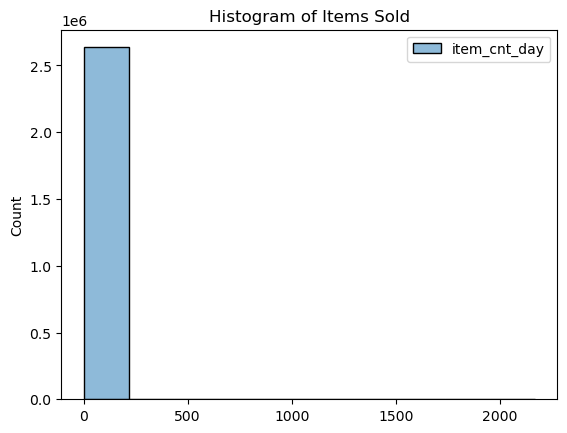

In [92]:
fig, ax = plt.subplots()
sns.histplot(items_not_returned, bins=10)
ax.set_title("Histogram of Items Sold")
plt.show()

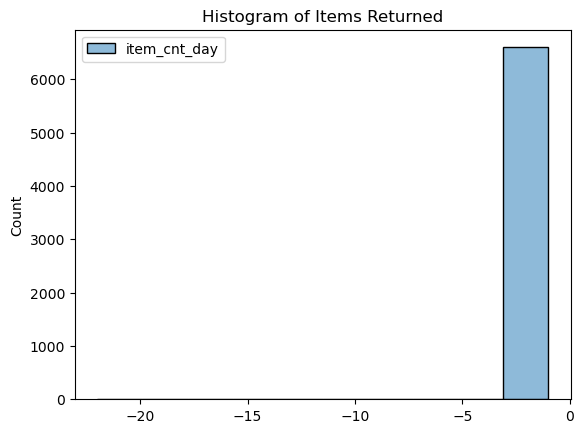

In [94]:
fig, ax = plt.subplots()
sns.histplot(items_returned, bins=10)
ax.set_title("Histogram of Items Returned")
plt.show()

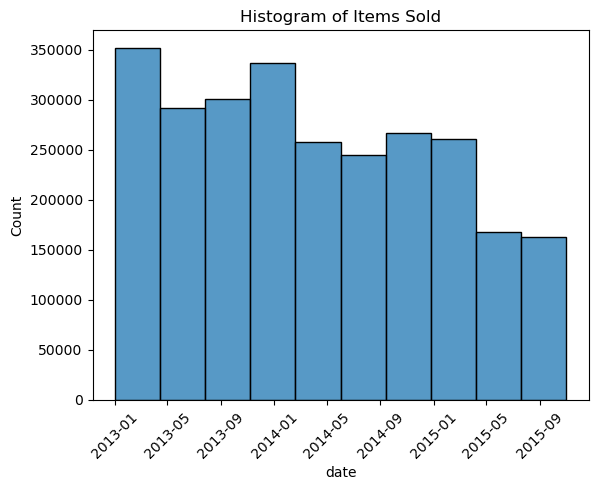

In [112]:
fig, ax = plt.subplots()
sns.histplot(stores_train_data["date"], bins=10)
ax.set_title("Histogram of Items Sold")
ax.tick_params(axis="x", rotation=45)
plt.show()